In [361]:
import pandas
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt

In [362]:
num_segments = 19
test_split = 0.3

In [363]:
data = pandas.read_csv('/home/carsten/workspaces/isws/models/predictions_cnn.csv')
num_test_songs = int(len(data)*test_split)

In [364]:
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

In [365]:
data = data.drop(['offset', 'duration', 'tempo', 'rms', 'mfcc18', 'mfcc19', 'mfcc20'],axis=1)
data.head()

,filename,chroma_stft,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
0,reggae.00009.wav,0.421017,1679.434736,2024.534270,3466.256905,0.064117,-262.811999,126.180913,11.227370,21.112270,...,0.017179,3.825630e-08,0.003677,0.002563,0.129292,0.000919,0.000036,0.022640,0.821978,0.001716
1,reggae.00009.wav,0.398483,1875.148780,2227.413557,4031.587601,0.069351,-220.923940,117.441621,4.900961,20.067881,...,0.021579,1.571213e-08,0.001592,0.000570,0.090843,0.002559,0.000011,0.008494,0.873763,0.000588
2,reggae.00009.wav,0.339041,1833.160181,2189.649126,3916.098976,0.067055,-206.509028,117.687803,3.399634,28.708057,...,0.070141,3.743988e-06,0.014839,0.002625,0.036685,0.015989,0.000090,0.010937,0.844721,0.003969
3,reggae.00009.wav,0.344620,1592.273248,2028.807317,3360.189056,0.054104,-232.590603,127.788885,7.052849,31.868343,...,0.062461,1.345654e-07,0.010381,0.001807,0.024071,0.002398,0.000039,0.006571,0.889641,0.002631
4,reggae.00009.wav,0.378558,1501.627471,1940.269736,3026.676750,0.051956,-243.499728,132.915085,4.320031,20.461475,...,0.009479,6.274756e-11,0.000977,0.001800,0.070580,0.000021,0.000003,0.019458,0.897005,0.000677


In [366]:
for i in range(len(data.filename)):
    res = data.iat[i,0]
    res = res.split('.')[0]
    data.iat[i,0] = res

In [367]:
genre_list = data.iloc[:, 0]
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(genre_list)

In [368]:
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, 1:], dtype = float))
np.array(data.iloc[:, 1:])

array([[4.21017349e-01, 1.67943474e+03, 2.02453427e+03, ...,
        2.26401150e-02, 8.21977560e-01, 1.71612670e-03],
       [3.98482721e-01, 1.87514878e+03, 2.22741356e+03, ...,
        8.49428400e-03, 8.73763440e-01, 5.87635790e-04],
       [3.39040828e-01, 1.83316018e+03, 2.18964913e+03, ...,
        1.09370030e-02, 8.44721140e-01, 3.96914080e-03],
       ...,
       [5.82671040e-01, 2.81592156e+03, 2.20142615e+03, ...,
        4.37898930e-03, 4.84908030e-04, 8.51978730e-02],
       [5.84403050e-01, 2.82644200e+03, 2.19657691e+03, ...,
        4.51797340e-03, 8.87173230e-05, 6.77375870e-02],
       [5.70103128e-01, 2.86434960e+03, 2.20523546e+03, ...,
        3.51290940e-03, 9.04673220e-05, 4.85153240e-02]])

In [369]:
X_test = X[:num_test_songs]
X_train = X[num_test_songs:]
y_test = y[:num_test_songs]
y_train = y[num_test_songs:]

In [370]:
from keras import models
from keras import layers

from keras.callbacks import EarlyStopping, ModelCheckpoint

In [371]:
val_split = int(19000*0.2)
x_val = X_train[:val_split]
partial_x_train = X_train[val_split:]

y_val = y_train[:val_split]
partial_y_train = y_train[val_split:]
x_norm = preprocessing.scale(x_val)

In [372]:
model = models.Sequential()
#model.add(layers.Dense(512, activation='relu', ))

model.add(layers.Dense(35, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(15, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=10),
                 ModelCheckpoint(filepath='./../../../models/ann-model-best.h5', monitor='val_loss', save_best_only=True)]

history = model.fit(partial_x_train,
          partial_y_train,
          epochs=200,
          batch_size=512,
          callbacks=callbacks,
          validation_data=(x_val, y_val))
results = model.evaluate(X_test, y_test)

Train on 9500 samples, validate on 3800 samples
Epoch 1/200
9500/9500 [==============================] - 1s 124us/step - loss: 2.2293 - acc: 0.1987 - val_loss: 2.0850 - val_acc: 0.3455
Epoch 2/200
9500/9500 [==============================] - 0s 10us/step - loss: 1.9452 - acc: 0.4200 - val_loss: 1.8023 - val_acc: 0.4655
Epoch 3/200
9500/9500 [==============================] - 0s 9us/step - loss: 1.6430 - acc: 0.5407 - val_loss: 1.5256 - val_acc: 0.5663
Epoch 4/200
9500/9500 [==============================] - 0s 9us/step - loss: 1.3550 - acc: 0.6391 - val_loss: 1.2615 - val_acc: 0.6361
Epoch 5/200
9500/9500 [==============================] - 0s 10us/step - loss: 1.0866 - acc: 0.7175 - val_loss: 1.0334 - val_acc: 0.7132
Epoch 6/200
9500/9500 [==============================] - 0s 9us/step - loss: 0.8609 - acc: 0.7740 - val_loss: 0.8771 - val_acc: 0.7471
Epoch 7/200
9500/9500 [==============================] - 0s 11us/step - loss: 0.7048 - acc: 0.8083 - val_loss: 0.7859 - val_acc: 0.7671
Ep

In [373]:
results

[1.3028600445232894, 0.68]

In [374]:
p = model.predict(X_test)

In [375]:
from sklearn.metrics import confusion_matrix
print(p.argmax(axis=1))
r = []
for int_res in p.argmax(axis=1):
    r.append(genres[int_res])
cm = confusion_matrix(encoder.inverse_transform(y_test), r, genres)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.around(cm, decimals=2)
print(genres)
print(cm)

[8 8 8 ... 5 5 5]
['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
[[0.74 0.   0.   0.01 0.05 0.06 0.08 0.   0.02 0.03]
 [0.01 0.95 0.   0.   0.01 0.02 0.   0.   0.   0.  ]
 [0.04 0.01 0.58 0.02 0.   0.07 0.01 0.08 0.04 0.17]
 [0.01 0.   0.02 0.63 0.08 0.   0.04 0.09 0.06 0.07]
 [0.   0.   0.   0.1  0.58 0.01 0.05 0.1  0.14 0.02]
 [0.11 0.07 0.11 0.01 0.01 0.64 0.   0.   0.03 0.02]
 [0.03 0.   0.   0.01 0.03 0.   0.8  0.   0.   0.13]
 [0.   0.   0.06 0.01 0.08 0.02 0.   0.78 0.03 0.02]
 [0.05 0.02 0.04 0.03 0.08 0.02 0.   0.02 0.73 0.02]
 [0.11 0.01 0.11 0.04 0.01 0.02 0.12 0.06 0.05 0.48]]


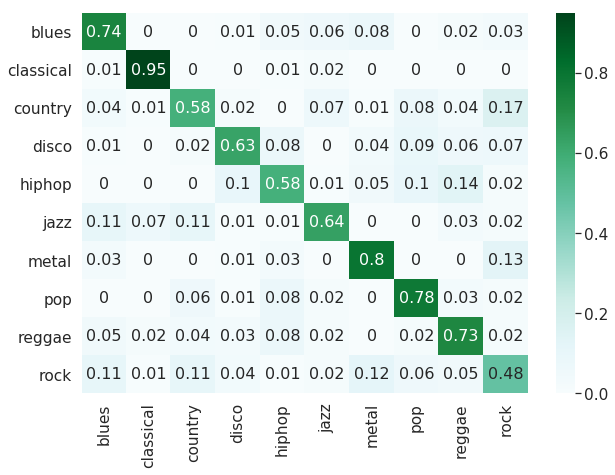

In [376]:
import pandas as pd, seaborn as sn, matplotlib.pyplot as plt
df_cm = pd.DataFrame(cm, genres,
                  genres)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size

ax=sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, cmap="BuGn")# font size

In [377]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


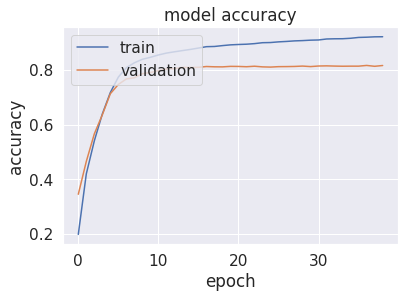

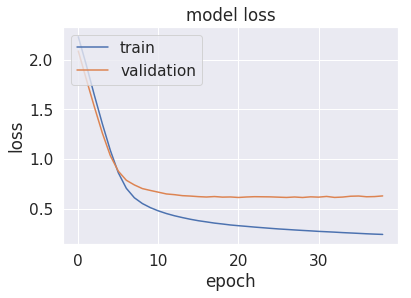

In [378]:
show_summary_stats(history)

In [379]:
def evaluate_songs(songdata=X_test, true_vals=y_test, model=model):
    pred_genres = []
    prediction = []
    true_genres = []
    predictions = model.predict(songdata)
    for i in range(len(predictions)):
        if i%19 == 0:
            true_genres.append(true_vals[i])
            pred_genres.append(prediction)
            prediction = predictions[i]        
        else:
            prediction = (prediction + predictions[i])/2
    pred_genres.append(prediction)
    np.delete(pred_genres, [0])
    return pred_genres, true_genres

In [380]:
len(X_test)
pred_genres, true_genres = evaluate_songs()
print(len(true_genres))
c = 0
for i in range(len(pred_genres)):
    if i != 0:
        if pred_genres[i].argmax(axis=0) == true_genres[i-1]:
            c = c + 1
print(c)
acc = c/len(true_genres)*100
print("Accuracy: " + str(acc) + "%")

300
216
Accuracy: 72.0%
